In [1]:
# Model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): 
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [2]:
# dqn_agent.py
import numpy as np
import random
from collections import namedtuple, deque

# from model import QNetwork
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5) # replay buffer size
BATCH_SIZE = 64 # minibatch size
GAMMA = 0.99 # discount factor
TAU = 1e-3 # for soft update of target parameter
LR = 5e-4 # learning rate
UPDATE_EVERY = 4 # how often to update the network

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent Object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERT steps)
        self.t_step = 4
        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilong-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experience (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values (for next sttes) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Get expected Q valjues from local mode
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # --------------------- update target network -------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameter.
        Q_target = τ*Q_local + (1-τ)*Q_target
        
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

In [3]:
class ReplayBuffer:
    """Fixed-size buffer to stor experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


# Deep Q-Network (DQN)
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [4]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent
Initialize the environment in the code cell below.

In [5]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Plasese refer to the instructions in `Deep_Q_Network.ipynb` if you would like to write your own DQN agent. Otherwise, run the code cell below to load the solution files.

In [6]:
# from dqn_agent import Agent
agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break;
        
env.close()

### 3. Train the Agent with DQN
Run the code cell below to train the agent from scratch, You are welcome to amend the supplied values of the parameters in the function, to try to see if you can better performance!

Alternatevely, you can skip to the next step below(**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.


Episode 1	Average Score: -116.47
Episode 2	Average Score: -266.34
Episode 3	Average Score: -236.69
Episode 4	Average Score: -201.19
Episode 5	Average Score: -206.47
Episode 6	Average Score: -226.88
Episode 7	Average Score: -224.03
Episode 8	Average Score: -205.73
Episode 9	Average Score: -192.05
Episode 10	Average Score: -184.10
Episode 11	Average Score: -178.18
Episode 12	Average Score: -173.88
Episode 13	Average Score: -186.45
Episode 14	Average Score: -207.03
Episode 15	Average Score: -200.54
Episode 16	Average Score: -207.20
Episode 17	Average Score: -202.28
Episode 18	Average Score: -195.59
Episode 19	Average Score: -208.83
Episode 20	Average Score: -218.85
Episode 21	Average Score: -213.97
Episode 22	Average Score: -218.06
Episode 23	Average Score: -213.64
Episode 24	Average Score: -208.11
Episode 25	Average Score: -200.17
Episode 26	Average Score: -194.80
Episode 27	Average Score: -192.33
Episode 28	Average Score: -196.70
Episode 29	Average Score: -196.29
Episode 30	Average Sco

Episode 237	Average Score: -65.71
Episode 238	Average Score: -65.19
Episode 239	Average Score: -65.67
Episode 240	Average Score: -64.00
Episode 241	Average Score: -62.76
Episode 242	Average Score: -63.79
Episode 243	Average Score: -63.49
Episode 244	Average Score: -63.59
Episode 245	Average Score: -63.23
Episode 246	Average Score: -62.46
Episode 247	Average Score: -61.92
Episode 248	Average Score: -62.05
Episode 249	Average Score: -62.62
Episode 250	Average Score: -62.00
Episode 251	Average Score: -61.02
Episode 252	Average Score: -59.49
Episode 253	Average Score: -59.00
Episode 254	Average Score: -61.21
Episode 255	Average Score: -61.31
Episode 256	Average Score: -60.55
Episode 257	Average Score: -59.72
Episode 258	Average Score: -59.54
Episode 259	Average Score: -59.93
Episode 260	Average Score: -60.26
Episode 261	Average Score: -59.36
Episode 262	Average Score: -59.08
Episode 263	Average Score: -58.92
Episode 264	Average Score: -58.48
Episode 265	Average Score: -60.09
Episode 266	Av

Episode 478	Average Score: 142.55
Episode 479	Average Score: 142.53
Episode 480	Average Score: 142.17
Episode 481	Average Score: 144.60
Episode 482	Average Score: 144.14
Episode 483	Average Score: 144.27
Episode 484	Average Score: 144.79
Episode 485	Average Score: 144.44
Episode 486	Average Score: 145.98
Episode 487	Average Score: 145.79
Episode 488	Average Score: 147.56
Episode 489	Average Score: 147.41
Episode 490	Average Score: 149.38
Episode 491	Average Score: 150.30
Episode 492	Average Score: 151.99
Episode 493	Average Score: 151.68
Episode 494	Average Score: 150.35
Episode 495	Average Score: 150.51
Episode 496	Average Score: 151.03
Episode 497	Average Score: 153.06
Episode 498	Average Score: 152.31
Episode 499	Average Score: 152.13
Episode 500	Average Score: 153.46\Episode 500	Average Score: 153.46

Episode 501	Average Score: 153.42
Episode 502	Average Score: 154.23
Episode 503	Average Score: 154.12
Episode 504	Average Score: 155.21
Episode 505	Average Score: 155.69
Episode 506	A

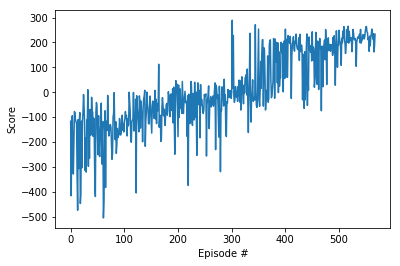

In [16]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greddy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score) # save most recent score
        scores.append(score) # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
        if i_episode % 100 == 0:
            print('\Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4.Watch a Smart Agent!
In the next code cell, you will load the trained weights from file to watch a smart agent!

In [9]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(20):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break
            
env.close()